## Zindi Financial Inclusion Challange
Using the dataset, I'm supposed to create a model that predicts if an individual has access to a bank account, an indication of financial inclusion

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
train = pd.read_csv('Train_v2.csv')
test = pd.read_csv('Test_v2.csv')

In [4]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


Just getting familiar with the data..........

In [5]:
train.shape

(23524, 13)

In [6]:
train.columns  #Features I'll be training the model on. Majority of them seem to be categorical

Index(['country', 'year', 'uniqueid', 'bank_account', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type'],
      dtype='object')

In [0]:
#There's essentially just 2 classes, Yes or No regarding bank accounts. Feels more comfortable replacing
#them with 1 and 0 respectively
def bin_converter(x):
    if x == 'Yes':
        return 1
    else:
        return 0

In [8]:
train['class'] = train['bank_account'].apply(bin_converter)
train['class']

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: class, Length: 23524, dtype: int64

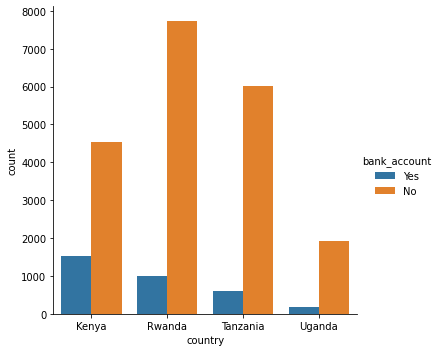

In [9]:
sns.catplot(x='country', hue='bank_account', kind='count', data=train)
#The vast majority of the people who took part in this survey apparently do not have accounts. Also worth noting
#the data from each country isn't particularly uniformly dispersed

In [0]:
#The age range is 16-100. Trying to get some insight from it, so I'll check out the chances of having an account
#if an individual is within the a particular age range (based on the survey data off course)
age_classes = []
class_mean = []
i = 15
class_width = 10 #Giving the age classes a width of 10, could also play around with this value, inference should be similar though

while(i<=100-class_width):
    age_class_df = train[train['age_of_respondent'].isin(range(i, i+class_width+1))] 
    age_class_mean = age_class_df['class'].mean()
    
    age_classes.append(str(i)+'-'+str(i+class_width))
    class_mean.append(age_class_mean)
    i += class_width

<BarContainer object of 8 artists>

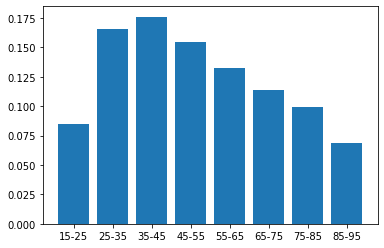

In [11]:
#Ok,so people within the age range of 35-45 have the highest chance of getting accounts, closely followed
#by individuals of 25-35. Looks like a normal distribution of sorts
plt.bar(age_classes, class_mean)

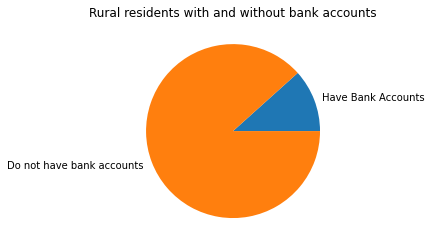

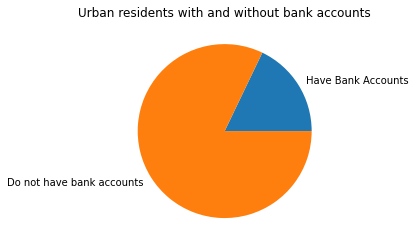

In [12]:
#An interesting insight would be how the location type feature affects the possibility of owning an account

#Doesn't seem to be much of a difference between the percentage of rural and urban residents with or without
#bank accounts, though there's a slightly higher percentage of urban residents with accounts

rural_df = train[train['location_type']=='Rural']
rur_with_ba = rural_df['class'].sum()
rur_wo_ba = rural_df['class'].count() - rur_with_ba

plt.pie([rur_with_ba, rur_wo_ba], labels=['Have Bank Accounts', 'Do not have bank accounts'])
plt.title('Rural residents with and without bank accounts')

plt.show()

urban_df = train[train['location_type']=='Urban']
ur_with_ba = urban_df['class'].sum()
ur_wo_ba = urban_df['class'].count() - ur_with_ba

plt.pie([ur_with_ba, ur_wo_ba], labels=['Have Bank Accounts', 'Do not have bank accounts'])
plt.title('Urban residents with and without bank accounts')

plt.show()

In [0]:
#Unfortunately, there's only 3 years worth of data in the survey, but doesn't hurt still checking
#for possible trends as the years pass with the percentage of people with accounts

years = sorted(train['year'].unique())
year_mean = []

for y in years:
    year_df = train[train['year'] == y]
    df_mean = year_df['class'].mean()
    
    year_mean.append(df_mean)

<BarContainer object of 3 artists>

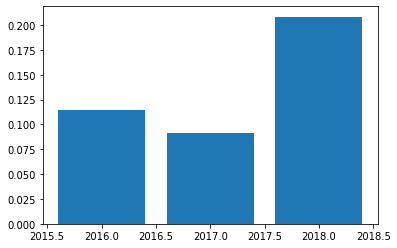

In [14]:
#Not much from the first two years, but there's a major increase in percentage of people with accounts
#in the last year

plt.bar(years, year_mean)

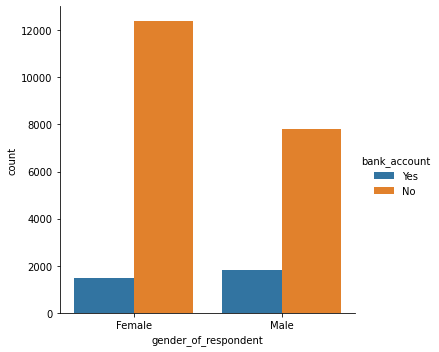

In [15]:
sns.catplot(x='gender_of_respondent', hue='bank_account', kind='count', data=train)
#Seems like slightly more males have accounts, but a lot more females are without them. To be fair, more women
#were part of the survey compared to men so from the country visuals, we should expect more men to be without accounts
#if the survey covered more males

In [0]:
#Lastly, I'll check out how the relationship with the head affects the possibility of having an account

ba_df = train[train['bank_account'] == 'Yes']
rwh = train['relationship_with_head'].unique()
rwh_count = []

for r in rwh:
    count = sum(ba_df['relationship_with_head'] == r)
    rwh_count.append(count)

([<matplotlib.patches.Wedge at 0x7fc76c0389e8>,
 [Text(1.3042544301829293, 1.0106534427528573, 'Spouse'),
  Text(-1.5593908736976758, -0.5392588460362985, 'Head of Household'),
  Text(1.371054834065775, -0.9179916350299007, 'Other relative'),
  Text(1.553151935248219, -0.5569731286468969, 'Child'),
  Text(1.6418230474758706, -0.16406425807300423, 'Parent'),
  Text(1.6497030973449311, -0.03130000975305962, 'Other non-relatives')])

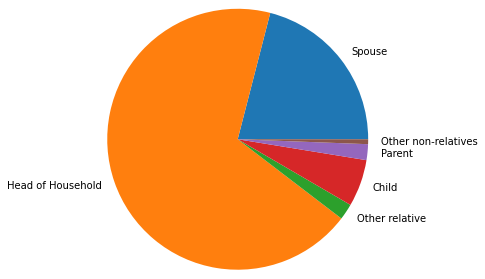

In [17]:
#The head of the house seems to dominate the number of people with accounts

plt.pie(x=rwh_count, labels=rwh, radius=1.5)

Looking through other features, there's a few predictables. For example, for the job type category individuals without a source of income are the group with the lowest probability of having bank accounts (based on the survey data).

Now, on to creating the model. Before training on the whole data I'd like to see how the model does on a part of the training data off course.

In [0]:
#Felt more comfortable treating the 'year' feature as categorical. Also helps that there's not many years I'm
#training on either way
train['year'] = train['year'].astype('str')

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['uniqueid', 'bank_account', 'class'], axis=1), train['class'], test_size=0.1, shuffle=True)

In [0]:
import tensorflow as tf

In [0]:
#As I said, it's mainly just categorical data I'm dealing with bar the ages and household size features

feat_cols = []

for feat in X_train.columns:
    if feat not in ['household_size', 'age_of_respondent']:
        tf_col = tf.feature_column.categorical_column_with_hash_bucket(feat, hash_bucket_size=len(train[feat].unique()))
        tf_col = tf.feature_column.embedding_column(tf_col, dimension=len(train[feat].unique()))
    else:
        tf_col = tf.feature_column.numeric_column(feat)
        
    feat_cols.append(tf_col)

In [23]:
feat_cols

[EmbeddingColumn(categorical_column=HashedCategoricalColumn(key='country', hash_bucket_size=4, dtype=tf.string), dimension=4, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fc76c08aa90>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True),
 EmbeddingColumn(categorical_column=HashedCategoricalColumn(key='year', hash_bucket_size=3, dtype=tf.string), dimension=3, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fc7332191d0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True),
 EmbeddingColumn(categorical_column=HashedCategoricalColumn(key='location_type', hash_bucket_size=2, dtype=tf.string), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fc733219208>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True),
 EmbeddingColumn(categorical_column=HashedCategoricalColumn(k

In [0]:
input_func = tf.estimator.inputs.pandas_input_fn(X_train, y_train, batch_size=10, num_epochs=1000, shuffle=True)

In [25]:
#Also checked accuracy levels with a normal LinearClassifier model, didn't make much of a difference so
#(due to my personal preference as well), I'll be using a DNNClassifier
model = tf.estimator.DNNClassifier(hidden_units=[10, 10, 10], feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp3iegkwh9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc733289e48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [26]:
#Annoying warnings..........
model.train(input_fn=input_func, steps=1000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was 

In [0]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(X_test, y_test, batch_size=10, num_epochs=1, shuffle=False)

In [28]:
#More annoying warnings........
results = model.evaluate(eval_input_func)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-27T22:09:48Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp3iegkwh9/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-03-27-22:09:50
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8759031, accuracy_baseline = 0.86315346, auc = 0.80653286, auc_precision_recall = 0.44914636, average_loss = 0.31999227, global_step = 1000, label/mean = 0.13684657, loss = 3.1904316, precision = 0.60714287, prediction/mean = 0.14244235, recall = 0.26397514
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmp3iegkwh9/model.ckpt-1000


In [29]:
# 87% accuracy, not bad I guess.
results

{'accuracy': 0.8759031,
 'accuracy_baseline': 0.86315346,
 'auc': 0.80653286,
 'auc_precision_recall': 0.44914636,
 'average_loss': 0.31999227,
 'global_step': 1000,
 'label/mean': 0.13684657,
 'loss': 3.1904316,
 'precision': 0.60714287,
 'prediction/mean': 0.14244235,
 'recall': 0.26397514}

In [30]:
#Now for the main model I'll train on the whole data
zn_model = tf.estimator.DNNClassifier(hidden_units=[10, 10, 10],feature_columns=feat_cols, n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp584pfvd1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc72bf2d9e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
input_func = tf.estimator.inputs.pandas_input_fn(train.drop(['uniqueid', 'bank_account', 'class'], axis=1), train['class'], batch_size=10, num_epochs=1000, shuffle=True)

In [32]:
zn_model.train(input_fn=input_func, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp584pfvd1/model.ckpt.
INFO:tensorflow:loss = 1.5086728, step = 1
INFO:tensorflow:global_step/sec: 160.224
INFO:tensorflow:loss = 4.003461, step = 101 (0.628 sec)
INFO:tensorflow:global_step/sec: 291.395
INFO:tensorflow:loss = 4.0332108, step = 201 (0.345 sec)
INFO:tensorflow:global_step/sec: 278.252
INFO:tensorflow:loss = 5.023321, step = 301 (0.356 sec)
INFO:tensorflow:global_step/sec: 256.945
INFO:tensorflow:loss = 5.54708, step = 401 (0.390 sec)
INFO:tensorflow:global_step/sec: 267.218
INFO:tensorflow:loss = 9.572213, step = 501 (0.378 sec)
INFO:tensorflow:global_step/sec: 237.665
INFO:tensorflow:loss = 2.1907098, step = 601 (0.417 sec)
INFO:tensorflow:global_step/sec: 269.695
INFO:tensorflow:loss 

Now that that's done, time to make predictions on the test dataset

In [33]:
test.head() #Test data

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent


In [0]:
test['year'] = test['year'].astype('str')

In [0]:
sub_file = pd.read_csv('SubmissionFile.csv')

In [36]:
sub_file.head() #Format to submit my predictions

,uniqueid,bank_account
0,uniqueid_7867 x Kenya,1.0
1,uniqueid_6722 x Kenya,0.0
2,uniqueid_6714 x Kenya,1.0
3,uniqueid_8103 x Kenya,1.0
4,uniqueid_8657 x Kenya,1.0


In [0]:
sub_file.set_index('uniqueid', inplace=True)

In [0]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(test.drop('uniqueid', axis=1), batch_size=10, num_epochs=1, shuffle=False)

In [0]:
pred = model.predict(pred_input_func)

In [40]:
predictions = list(pred)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp3iegkwh9/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [0]:
my_pred = [float(pred['class_ids'][0]) for pred in predictions]

In [42]:
my_pred[:5]

[1.0, 1.0, 0.0, 0.0, 0.0]

In [0]:
idxc = []
for i in range(test.shape[0]):
    idxc.append(test.loc[i, 'uniqueid'] + ' x ' + test.loc[i, 'country'])

In [44]:
idxc[:5]

['uniqueid_6056 x Kenya',
 'uniqueid_6060 x Kenya',
 'uniqueid_6065 x Kenya',
 'uniqueid_6072 x Kenya',
 'uniqueid_6073 x Kenya']

In [0]:
id_dict = dict(zip(idxc, my_pred))

In [0]:
for id in id_dict.keys():
    sub_file.loc[id] = id_dict[id]

In [0]:
sub_file.reset_index(inplace=True)

In [48]:
sub_file #Ok, finally have my predictions for each person on the test data

,uniqueid,bank_account
0,uniqueid_7867 x Kenya,0.0
1,uniqueid_6722 x Kenya,0.0
2,uniqueid_6714 x Kenya,0.0
3,uniqueid_8103 x Kenya,0.0
4,uniqueid_8657 x Kenya,0.0
...,...,...
10081,uniqueid_2311 x Uganda,0.0
10082,uniqueid_2921 x Uganda,0.0
10083,uniqueid_2280 x Uganda,1.0
10084,uniqueid_2285 x Uganda,1.0


In [0]:
sub_file.to_csv('my_submission.csv', index=False)